# CSCI 403 Project 9: Bitcoin, Tesla, and Air Pollution

### David Esposito, Noor Malik, Ibrohim Nosirov

## Introduction

The electric car manufacturer, Tesla, and the cryptocurrency, Bitcoin, have enjoyed a meteoric, and occasionally polarizing, rise in the past decade. With an army of ardent supporters active on the Internet, both Tesla and Bitcoin have walked a fine line between industry-disrupting phenomenon and speculative fluke not to be taken too seriously. In recent years, the environmental impacts of Bitcoin have been called into question while the Tesla CEO, Elon Musk, has similarly been criticized for what critics claim to be a disingenuous commitment to environmentalism. All of this has taken place against a steady increase in the rate of global $CO_2$ emissions over the past decade. In this paper we explore some of the potential correlations arising from data documenting the rise of Tesla, Bitcoin, and global emissions through much of the past decade.

### A Note on Jupyter Notebook-Database Interaction

We chose to work in Python for this exploration, so we needed an efficient way of querying the database without explicitly loading into a large DataFrame object. We found the package psycopg2 to be the most convenient solution. It allowed us to establish a connection with the Mines csci403 server using our credentials and we could use the cursor to seamlessly pass queries throughout the rest of the session. Once we retrieved the raw data, we turned to the usual data science packages: NumPy, Pandas, and Matplotlib.

In [21]:
import psycopg2 as pg
import getpass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
user = input("Username: ")
password = getpass.getpass("Password: ")
conn = pg.connect(dbname='csci403', user=user, password=password, host='codd.mines.edu', port='5433')
del user
del password
cur = conn.cursor()

## Data

We consider three separate datasets, from the website Kaggle.com, for this exploration. The [Air Pollution dataset](https://www.kaggle.com/kweinmeister/pm25-global-air-pollution-20102017) contains information on the mean annual $CO_2$ exposure (micrograms per cubic meter) for 240 countries from 2010 to 2017. Understandably, this dataset is rather small with only 240 rows and 10 columns. This dataset is available under a Creative Commons license.

In [23]:
query = """SELECT * FROM pollution;"""
cur.execute(query)
sql_table_pollution = cur.fetchall()
df_pollution = pd.DataFrame(sql_table_pollution, columns=['country_name', 'country_code', '2010', '2011', '2012', '2013','2014','2015','2016','2017'])
df_pollution

,country_name,country_code,2010,2011,2012,2013,2014,2015,2016,2017
0,Afghanistan,AFG,65.245592,66.835727,66.023174,61.366745,59.010330,61.252656,56.287047,56.910808
1,Angola,AGO,33.787247,33.104195,33.415495,34.663923,32.974025,32.729873,31.785389,32.388505
2,Albania,ALB,21.277828,22.772537,20.578259,19.938517,18.883955,19.512540,18.189934,18.200603
3,Andorra,AND,12.807197,13.273506,12.407053,11.813673,10.830418,11.462178,10.255834,10.307621
4,Arab World,ARB,53.787001,52.652279,53.297270,54.053822,52.583603,60.406813,58.764905,58.689259
...,...,...,...,...,...,...,...,...,...,...
235,Samoa,WSM,14.288094,14.693096,13.627882,13.382522,12.643560,12.321796,11.366298,11.548027
236,"Yemen, Rep.",YEM,45.979470,50.835291,51.434454,52.998443,48.338653,54.260287,50.127626,50.456007
237,South Africa,ZAF,27.138587,26.557873,26.577087,26.729262,26.722212,26.112972,25.140416,25.102205
238,Zambia,ZMB,28.836379,28.987117,29.742040,29.112221,28.493252,28.375452,27.355674,27.438035


Next, we consider the
[Tesla Stock dataset](https://www.kaggle.com/timoboz/tesla-stock-data-from-2010-to-2020). The original dataset was made available through [Yahoo Finance](https://finance.yahoo.com/quote/TSLA) and, according to Kaggle, they hold a copyright over the original data. This dataset contains daily stock prices for the company starting from 2010 and through 2020. There ~2400 data points and while the original dataset contains 7 columns, much of the data (i.e. opening price, closing price, trading volume...) is irrelevant to this study. In fact, we are only concerned with the stock price and the corresponding date. In the section on preprocessing, we discuss the technical challenges of properly cleaning the data.

In [24]:
query = """SELECT * FROM tsla;"""
cur.execute(query)
sql_table_tsla = cur.fetchall()
df_tsla = pd.DataFrame(sql_table_tsla, columns=['Date', 'Stock Price (\$)'])
df_tsla

,Date,Stock Price (\$)
0,2010-06-29,19.00
1,2010-06-30,25.79
2,2010-07-01,25.00
3,2010-07-02,23.00
4,2010-07-06,20.00
...,...,...
2411,2020-01-28,568.49
2412,2020-01-29,575.69
2413,2020-01-30,632.42
2414,2020-01-31,640.00


Finally, we consider the [Bitcoin Price dataset](https://www.kaggle.com/aditeloo/bitcoin).
Similar to the Tesla dataset, it contains data on the daily price of bitcoin from 2010 through 2018. As it is not bound to the stock market closures, this dataset has more data than the Tesla dataset. The original dataset contains 24 columns, but once again, we choose only the columns we deem most relevant to this exploration. This dataset is in the public domain.

In [25]:
query = """SELECT * FROM btc;"""
cur.execute(query)
sql_table = cur.fetchall()
df_btc = pd.DataFrame(sql_table, columns=['day', 'price', 'total_btc', 'hash_rate', 'difficulty', 'output_volume'])
df_btc

,day,price,total_btc,hash_rate,difficulty,output_volume
0,2010-02-17,0.0,2043200.0,2.920000e-05,2.527740e+00,65173.10
1,2010-02-18,0.0,2054650.0,2.880000e-05,2.527740e+00,18911.70
2,2010-02-19,0.0,2063600.0,2.250000e-05,2.527740e+00,9749.98
3,2010-02-20,0.0,2074700.0,2.790000e-05,2.527740e+00,11150.00
4,2010-02-21,0.0,2085400.0,2.690000e-05,2.527740e+00,12266.80
...,...,...,...,...,...,...
2901,2018-01-27,11524.8,16830300.0,2.031570e+07,2.600000e+12,1363300.00
2902,2018-01-28,11765.7,16832300.0,2.044510e+07,2.600000e+12,3128910.00
2903,2018-01-29,11212.7,16834100.0,1.915120e+07,2.600000e+12,1941050.00
2904,2018-01-30,10184.1,16836200.0,2.160970e+07,2.600000e+12,2359670.00


## Preprocessing

## Database Creation

## Data Visualization/Exploration

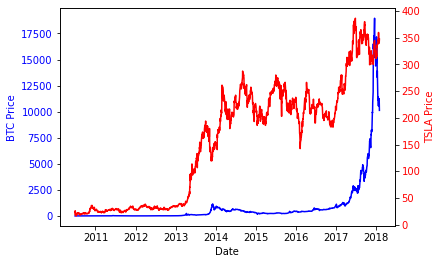

In [26]:
query = """SELECT tsla.day, tsla.price, btc.price FROM tsla, btc WHERE tsla.day = btc.day;"""
cur.execute(query)
sql_table = cur.fetchall()
df = pd.DataFrame(sql_table, columns=['day', 'tsla_price', 'btc_price'])

fig, ax1 = plt.subplots()
ax1.plot(df['day'], df['btc_price'], color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(df['day'], df['tsla_price'], color='red')
ax2.set_ylabel('TSLA Price', color='red')
ax2.tick_params(axis='y', labelcolor='red')

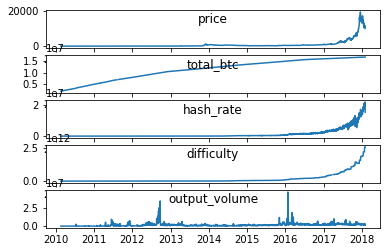

In [27]:
fig, ax = plt.subplots(5)
for i, name in enumerate(df_btc.columns[1:]):
    ax[i].plot(df_btc['day'], df_btc[name])
    ax[i].set_title(name, y=0.5)

[[1.         0.39444191]
 [0.39444191 1.        ]]


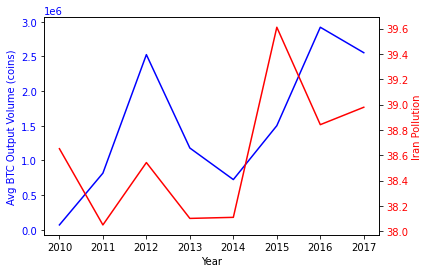

In [28]:
query = """SELECT EXTRACT(YEAR FROM day), AVG(output_volume) FROM btc GROUP BY EXTRACT(YEAR FROM day) ORDER BY EXTRACT(YEAR FROM day);"""
cur.execute(query)

btc_avg_output = cur.fetchall()
df_btc_avg_output = pd.DataFrame(btc_avg_output, columns=['year','avg_output'])

iran = df_pollution[df_pollution['country_code']=='IRN']
iran = iran.drop(columns=['country_name', 'country_code'])
iran = np.reshape(iran.to_numpy(), -1)
btc_avg_output = df_btc_avg_output['avg_output'][:-1]

fig, ax1 = plt.subplots()
ax1.plot(range(2010,2018), btc_avg_output, color='blue')
ax1.set_xlabel('Year')
ax1.set_ylabel('Avg BTC Output Volume (coins)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(range(2010,2018), iran, color='red')
ax2.set_ylabel('Iran Pollution', color='red')
ax2.tick_params(axis='y', labelcolor='red')

print(np.corrcoef(btc_avg_output, iran))

In [31]:
# Generating the world map

# Reference Code:       https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10
# Folium Documentation: https://python-visualization.github.io/folium/modules.html

from pycountry_convert import country_name_to_country_alpha3
from geopy.geocoders import Nominatim
 
geolocator = Nominatim(user_agent='pollution-map')
df_coords = pd.DataFrame({'country_name':[], 'latitude':[], 'longitude':[]})

for country in df_pollution['country_name']:
    try:
        a2_code = country_name_to_country_alpha3(country)
        loc = geolocator.geocode(country)
        df_coords.loc[len(df_coords.index)] = [country, loc.latitude, loc.longitude]
    except:
        print('Couldn\'t find country', country)

import folium
from folium.plugins import MarkerCluster

world_map = folium.Map(tiles="cartodbpositron")
pollution_max = max(df_pollution['2017'])

for i in range(len(df_coords)):
    lat = df_coords.iloc[i]['latitude']
    lon = df_coords.iloc[i]['longitude']

    pollution_row = df_pollution[df_pollution['country_name'] == df_coords.iloc[i]['country_name']]
    pollution = int(pollution_row['2017'])

    popup_text = """Country : {}<br><br>2017 Air Quality Rating : {}<br>"""
    popup_text = popup_text.format(df_coords.iloc[i]['country_name'], pollution)

    dot_color = 'green'
    if (pollution > pollution_max/4):
        dot_color = 'orange'
    if (pollution > pollution_max/2):
        dot_color = 'red'
    if (pollution > 3*pollution_max/4):
        dot_color = 'purple'

    folium.CircleMarker(location=[lat, lon], radius=30*pollution/pollution_max, popup=popup_text, fill=True, color=dot_color).add_to(world_map)

world_map
        

Couldn't find country Arab World
Couldn't find country Bahamas, The
Couldn't find country Central Europe and the Baltics
Couldn't find country Cote d'Ivoire
Couldn't find country Congo, Dem. Rep.
Couldn't find country Congo, Rep.
Couldn't find country Caribbean small states
Couldn't find country East Asia & Pacific (excluding high income)
Couldn't find country Early-demographic dividend
Couldn't find country East Asia & Pacific
Couldn't find country Europe & Central Asia (excluding high income)
Couldn't find country Europe & Central Asia
Couldn't find country Egypt, Arab Rep.
Couldn't find country Euro area
Couldn't find country European Union
Couldn't find country Fragile and conflict affected situations
Couldn't find country Micronesia, Fed. Sts.
Couldn't find country Gambia, The
Couldn't find country High income
Couldn't find country Heavily indebted poor countries (HIPC)
Couldn't find country IBRD only
Couldn't find country IDA & IBRD total
Couldn't find country IDA total
Couldn't 

## Hypothesis Testing

## Results

## Challenges